3. Regression Analysis: Predicting Bitcoin Price
Project: CryptoGigel

Objective: In this notebook, we train 5 different Machine Learning models to predict the exact closing price of Bitcoin for the next day (Target_Next_Close).

Workflow:

Load Processed Data: Import the dataset created in step 2.

Time Series Split: Divide data into Train (Past) and Test (Future) sets.

Scaling: Normalize features for distance-based algorithms (like KNN).

Model Training: Train Linear, Ridge, Lasso, KNN, and Decision Trees.

Evaluation: Compare models using RMSE (Error in $) and R2 Score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set visual style
sns.set_style("whitegrid")

# Load the processed data from Step 2
file_path = '../data/processed/bitcoin_processed.csv'
df = pd.read_csv(file_path, index_col=0) # Index col 0 is Date

print(f"Data loaded successfully. Shape: {df.shape}")
display(df.head())

Data loaded successfully. Shape: (1766, 12)


,Close,High,Low,Open,Volume,SMA_7,SMA_30,Pct_Change,Volatility,RSI,Target_Next_Close,Target_Direction
Date,,,,,,,,,,,,
2020-01-30,9508.993164,9553.125977,9230.897461,9316.016602,32378792851,8929.163504,8357.228516,0.020647,470.926122,67.269514,9350.529297,0
2020-01-31,9350.529297,9521.706055,9230.776367,9508.313477,29432489719,9058.462751,8428.907015,-0.016665,439.157500,59.464896,9392.875000,1
2020-02-01,9392.875000,9439.323242,9313.239258,9346.357422,25922656496,9204.895229,8509.153841,0.004529,327.093490,59.978513,9344.365234,0
2020-02-02,9344.365234,9468.797852,9217.824219,9389.820312,30835736946,9311.685965,8575.803206,-0.005165,187.891694,65.434974,9293.521484,0
2020-02-03,9293.521484,9540.372070,9248.633789,9344.683594,30934096509,9366.500558,8638.565365,-0.005441,70.261911,65.364105,9180.962891,0


2. Feature Selection
We need to separate the Inputs (X) from the Output (y).

X (Features): We include Price history (Open, Close, etc.), Volume, and our calculated Technical Indicators (RSI, SMA, Volatility).

y (Target): We are predicting Target_Next_Close.

Excluded: We must remove Target_Direction (used for classification) to avoid confusion.

In [4]:
# Select Features (Inputs)
# We drop the Targets and the raw 'Date' is already the index
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'SMA_7', 'SMA_30', 'Pct_Change', 'Volatility', 'RSI']

X = df[feature_cols]

# Select Target for Regression
y = df['Target_Next_Close']

print(f"Features selected ({len(feature_cols)}): {feature_cols}")
print("Target variable: Target_Next_Close")

Features selected (10): ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_7', 'SMA_30', 'Pct_Change', 'Volatility', 'RSI']
Target variable: Target_Next_Close


3. Train-Test Split (The "Time Series" Rule)
This is the most critical step in financial ML.

Standard ML: We usually shuffle data (shuffle=True) to ensure randomness.

Time Series ML: We MUST NOT shuffle. We cannot train on data from 2024 to predict prices in 2021. That would be "Data Leakage" (cheating).

Strategy: We take the first 80% of days for training (Past) and the last 20% for testing (Future).

In [6]:
# Split data into training and testing sets
# IMPORTANT: shuffle=False because this is Time Series data. 
# We cannot train on 2024 data to predict 2021 data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training Data: {X_train.shape[0]} samples (From start to {X_train.index[-1]})")
print(f"Testing Data:  {X_test.shape[0]} samples (From {X_test.index[0]} to end)")

Training Data: 1412 samples (From start to 2023-12-11)
Testing Data:  354 samples (From 2023-12-12 to end)


4. Feature Scaling
Algorithms like KNN and Linear Regression (with regularization) are sensitive to the scale of numbers.

Example: Volume is in billions ($30,000,000,000), while RSI is 0-100. Without scaling, the model would think Volume is the only thing that matters.

StandardScaler: Transforms data so mean = 0 and variance = 1.

Note: We .fit() only on X_train to simulate a real-world scenario where we don't know the future test data stats.

In [7]:
# Initialize Scaler
scaler = StandardScaler()

# Fit on training data ONLY, then transform both
# This prevents information from the test set leaking into the training process
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling/debugging
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Data scaled successfully.")

Data scaled successfully.


5. Model Initialization
We will test 5 different algorithms to see which logic fits Bitcoin best:

Linear Regression: The baseline. Assumes a straight-line trend.

Ridge & Lasso: Linear models with "Regularization" to prevent overfitting (good for noisy financial data).

KNN (K-Nearest Neighbors): Looks for similar days in the past.

Decision Tree: Uses if-then rules to predict price.

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Dictionary of models to train
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),   # L2 Regularization
    "Lasso Regression": Lasso(alpha=0.1),   # L1 Regularization
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42)
}

print("Models initialized and ready for training.")

Models initialized and ready for training.


6. Training & Evaluation Loop
We iterate through each model, train it on the history (X_train), and ask it to predict the future (X_test). Metrics used:

RMSE (Root Mean Squared Error): The average error in Dollars ($). Lower is better.

R2 Score: How well the model explains the variance. 1.0 is perfect. Higher is better.

In [1]:
results = []

print("Starting training loop...")

for name, model in models.items():
    # 1. Train the model
    model.fit(X_train_scaled, y_train)
    
    # 2. Make predictions on unseen data
    predictions = model.predict(X_test_scaled)
    
    # 3. Calculate Metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)                                # Error in USD
    mae = mean_absolute_error(y_test, predictions)     # Average absolute error
    r2 = r2_score(y_test, predictions)                 # Goodness of fit (0 to 1)
    
    # 4. Save results
    results.append({
        "Model": name,
        "RMSE (USD)": rmse,
        "MAE (USD)": mae,
        "R2 Score": r2
    })
    print(f"--> {name} trained. RMSE: ${rmse:.2f}")

# Create DataFrame for easy comparison
results_df = pd.DataFrame(results).sort_values(by="RMSE (USD)")
display(results_df)

Starting training loop...


NameError: name 'models' is not defined

7. Performance Visualization
Numbers are good, charts are better.

RMSE Chart: Shows which model has the smallest error.

R2 Chart: Shows which model "understands" the trend best.

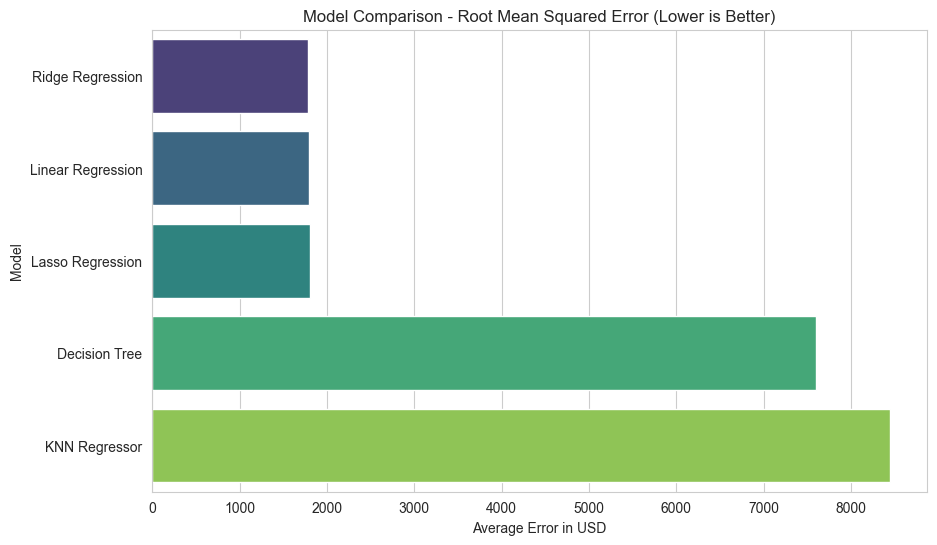

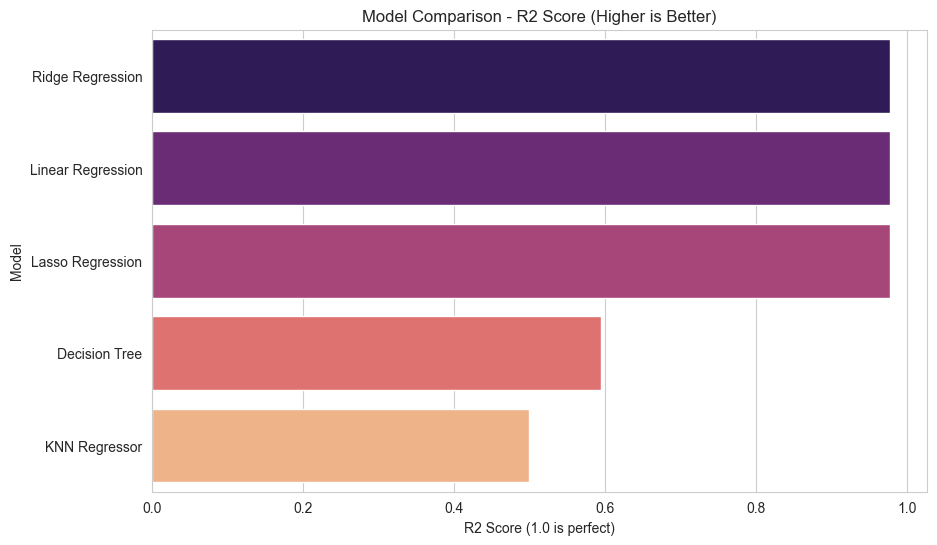

In [10]:
# Plot RMSE Comparison (Lower is better)
plt.figure(figsize=(10, 6))
# Note: Added hue=Model to avoid Seaborn FutureWarnings
sns.barplot(x="RMSE (USD)", y="Model", data=results_df, palette="viridis", hue="Model", legend=False)
plt.title("Model Comparison - Root Mean Squared Error (Lower is Better)")
plt.xlabel("Average Error in USD")
plt.show()

# Plot R2 Score Comparison (Higher is better)
plt.figure(figsize=(10, 6))
sns.barplot(x="R2 Score", y="Model", data=results_df, palette="magma", hue="Model", legend=False)
plt.title("Model Comparison - R2 Score (Higher is Better)")
plt.xlabel("R2 Score (1.0 is perfect)")
plt.show()

8. Prediction vs Reality
Let's visualize the "Best Model" in action. We plot the Actual Prices (Blue) vs the Predicted Prices (Red).

Analysis: If the Red line follows the Blue line closely, the model has successfully learned the market trend. If there is a lag, it means the model is reactive rather than predictive.

Visualizing best model: Ridge Regression


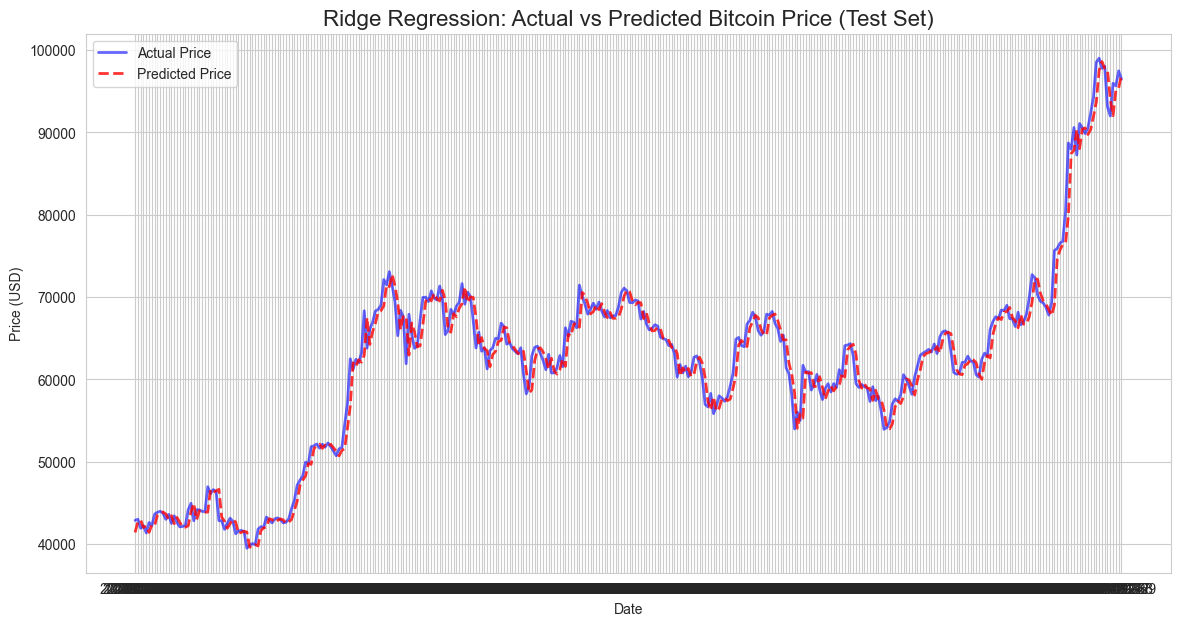

In [11]:
# Let's visualize the Linear Regression predictions (usually the best baseline for trending assets)
best_model_name = results_df.iloc[0]['Model']
print(f"Visualizing best model: {best_model_name}")

best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)
preds = best_model.predict(X_test_scaled)

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue', alpha=0.6, linewidth=2)
plt.plot(y_test.index, preds, label='Predicted Price', color='red', linestyle='--', alpha=0.8, linewidth=2)

plt.title(f'{best_model_name}: Actual vs Predicted Bitcoin Price (Test Set)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()